<a href="https://colab.research.google.com/github/Mollylst/DeepFake-Project/blob/main/ResNet18_FFHQ_stylegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/train-fake-stylegan1.zip' -d /content/train
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/train_real.zip' -d /content/train
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/test-fake-stylegan1.zip' -d /content/test
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/test_real.zip' -d /content/test

In [ ]:
import torch
import torchvision
import os
from torchvision import datasets 
import torchvision.transforms as transforms
from torch.utils.data import random_split

#prepare dataset and preprocessing
data_dir='/content/dataset'

transform_train = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5184, 0.4233, 0.3776], [0.2795, 0.2535, 0.2548])
])

transform_test = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize([0.5184, 0.4233, 0.3776], [0.2795, 0.2535, 0.2548])
])

batch_size = 128

trainset_total = datasets.ImageFolder(data_dir+'/train',transform=transform_train)

#length_train=int(len(trainset_total)*0.8)

#trainset,validset=random_split(trainset_total,[length_train,len(trainset_total)-length_train])

trainset,validset=random_split(trainset_total,[16000,2000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = datasets.ImageFolder(data_dir+'/test',transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x)) for x in ['train', 'test']}
classes = image_datasets['train'].classes
print(classes)
#classes = ('fake', 'real')

['fake', 'real']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images-size: torch.Size([128, 3, 128, 128])


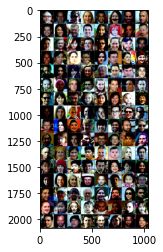

 real  fake  fake  real  fake  real  real  fake  real  fake  real  real  real  real  fake  real  fake  fake  real  fake  real  fake  fake  real  fake  real  real  fake  fake  fake  real  fake  real  fake  real  real  real  real  real  real  real  real  real  fake  fake  real  real  real  fake  fake  real  fake  fake  fake  real  fake  fake  real  real  fake  real  real  real  fake  real  real  real  fake  fake  fake  real  fake  real  real  real  real  fake  fake  fake  real  fake  real  real  real  real  real  real  real  fake  real  fake  fake  real  real  fake  fake  real  fake  fake  fake  fake  real  real  fake  real  fake  real  fake  real  real  fake  real  real  fake  real  real  real  fake  fake  fake  fake  fake  real  real  real  fake  real  real


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


print("images-size:", images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
def save_checkpoint(state, filename="./drive/MyDrive/Resnet18-FFHQ-stylegan-my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)
    
def load_checkpoint(checkpoint, net, optimizer):
    print("=> Loading checkpoint")
    net.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(out.shape[0],-1)
        #out = F.avg_pool2d(out, 4)
        #out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

#define ResNet18
net = ResNet18().to(device)

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0, last_epoch=-1, verbose=False)

load_checkpoint(torch.load("my_checkpoint.pth.tar"), net, optimizer)

Epoch: 1/50
Epoch: 001, Training: Loss: 0.7441, Accuracy: 51.7062%, 
		Validation: Loss: 0.6935, Accuracy: 52.3500%, Time: 111.5395s
Best Accuracy for validation : 0.5235 at epoch 001
Epoch: 2/50
Epoch: 002, Training: Loss: 0.6956, Accuracy: 53.4875%, 
		Validation: Loss: 0.6809, Accuracy: 56.1500%, Time: 111.4311s
Best Accuracy for validation : 0.5615 at epoch 002
Epoch: 3/50
Epoch: 003, Training: Loss: 0.6786, Accuracy: 57.2937%, 
		Validation: Loss: 0.6842, Accuracy: 58.7000%, Time: 111.3705s
Best Accuracy for validation : 0.5870 at epoch 003
Epoch: 4/50
Epoch: 004, Training: Loss: 0.5430, Accuracy: 71.7250%, 
		Validation: Loss: 0.4587, Accuracy: 77.8500%, Time: 111.3504s
Best Accuracy for validation : 0.7785 at epoch 004
Epoch: 5/50
Epoch: 005, Training: Loss: 0.3536, Accuracy: 84.3625%, 
		Validation: Loss: 0.4800, Accuracy: 75.9500%, Time: 111.2058s
Best Accuracy for validation : 0.7785 at epoch 004
Epoch: 6/50
Epoch: 006, Training: Loss: 0.2354, Accuracy: 90.0375%, 
		Validatio

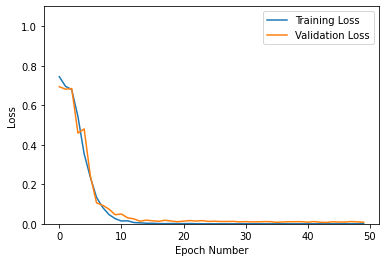

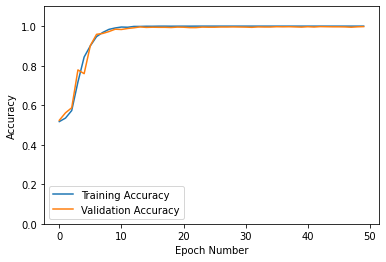

In [ ]:
import time
num_epoch=50
path='./drive/MyDrive/Resnet18-FFHQ-stylegan.pth'

def train_and_valid():
    history = []
    best_acc = 0.0
    best_epoch = 0
    
    for epoch in range(0,num_epoch):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, num_epoch))
        
        # Try save checkpoint
        if epoch==49:
          checkpoint = {"state_dict": net.state_dict(), "optimizer": optimizer.state_dict()}
          save_checkpoint(checkpoint)

        net.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        #train
        for i, (inputs, labels) in enumerate(trainloader):

            inputs, labels = inputs.to(device), labels.to(device)
 
            #the gradient is increasing, so make it zero
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
 
            train_loss += loss.item() * inputs.size(0)
            _,predictions = torch.max(outputs.data, 1)
            train_acc += (predictions == labels).sum().item()

        #validation
        net.eval()
        with torch.no_grad():

            for j, (inputs, labels) in enumerate(validloader):

                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                _,predictions = torch.max(outputs.data, 1)
                valid_acc += (predictions == labels).sum().item()
 
        avg_train_loss = train_loss/ len(trainset)
        avg_train_acc = train_acc/ len(trainset)
 
        avg_valid_loss = valid_loss/ len(validset)
        avg_valid_acc = valid_acc/ len(validset)

        #record the accuracy and loss in each epoch
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
 
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(net.state_dict(),path)
        scheduler.step()  

        epoch_end = time.time()
        
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
          
    return history
    
#start training and testing
history = train_and_valid()

#make the plots
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


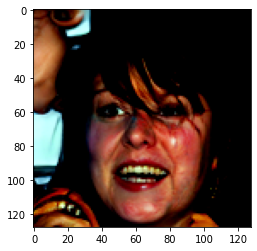

Predicted:  real   GroundTruth:  fake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


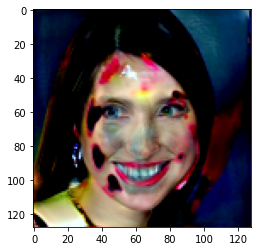

Predicted:  real   GroundTruth:  fake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


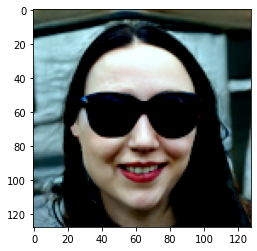

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  real   GroundTruth:  fake


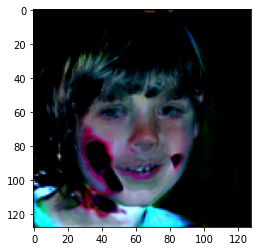

Predicted:  real   GroundTruth:  fake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


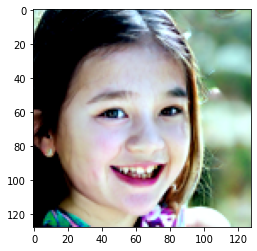

Predicted:  real   GroundTruth:  fake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


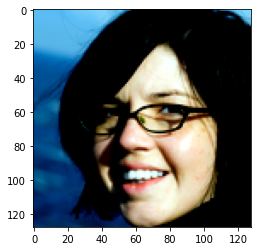

Predicted:  fake   GroundTruth:  real


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


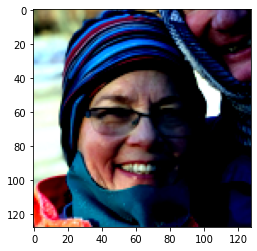

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:  fake   GroundTruth:  real


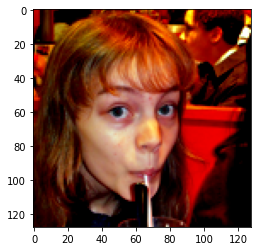

Predicted:  fake   GroundTruth:  real
Accuracy of the network on the test images: 99.600 %


In [ ]:
path='./drive/MyDrive/Resnet18-FFHQ-stylegan.pth'
net.load_state_dict(torch.load(path))
correct = 0
total = 0
net.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(len(inputs)):
          if classes[predicted[i]] != classes[labels[i]]:
            w_images = inputs[i].cpu()
            imshow(w_images)
            print('Predicted:', ''.join('%5s' % classes[predicted[i]] ),'  GroundTruth:',''.join('%5s' % classes[labels[i]]))

print('Accuracy of the network on the test images: %.3f %%' % (
    100 * correct / total))